# PCA + Neural Network Classifier with MNIST


## Libraries

In [1]:
# libraries
#using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
#using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

In [3]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

function batchImage2DF(imagesArray3D)
    vectorOfImageVectors = batchImage2Vector(imagesArray3D)
    M = reduce(hcat, vectorOfImageVectors)
    DataFrame(M', :auto)
end


batchImage2DF (generic function with 1 method)

## Loading the data

,,,,

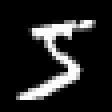
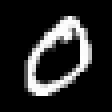
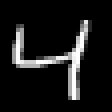
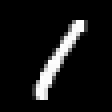
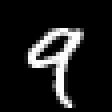

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [5]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Data preprocessing depends on the data source, thus can widely vary from what is shown here.

In [6]:
function preprocessing(X, y)
    newX = batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X, y = preprocessing(trainX, trainY);

In [7]:
scitype(X)

Table{AbstractVector{Continuous}}

In [8]:
scitype(y)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

## Training, Testing, Validation

### Load and pipe algorithms

In [9]:
# reduce predictors
PCA = @load PCA pkg=MultivariateStats verbosity=0
reducer = PCA(pratio = 0.95)

PCA(
    maxoutdim = 0,
    method = :auto,
    pratio = 0.95,
    mean = nothing)

In [10]:
# standardize predictors
stand = Standardizer();

In [11]:
# nnet
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux verbosity=0
nnet = NeuralNetworkClassifier(acceleration=CUDALibs())

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    rng = Random._GLOBAL_RNG(),
    optimiser_changes_trigger_retraining = false,
    acceleration = CUDALibs{Nothing}(nothing))

In [12]:
pipe = @pipeline reducer stand nnet

Pipeline294(
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.95,
            mean = nothing),
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    neural_network_classifier = NeuralNetworkClassifier(
            builder = Short,
            finaliser = NNlib.softmax,
            optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()),
            loss = Flux.Losses.crossentropy,
            epochs = 10,
            batch_size = 1,
            lambda = 0.0,
            alpha = 0.0,
            rng = Random._GLOBAL_RNG(),
            optimiser_changes_trigger_retraining = false,
            acceleration = CUDALibs{Nothing}(nothing)))

### Create and train the machine


In [13]:
pipe.neural_network_classifier.epochs=1
mach = MLJ.machine(pipe, X, y) |> fit!;

┌ Info: Training Machine{Pipeline294,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{PCA,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464


In [14]:
fitted_params(mach)

(neural_network_classifier = (chain = Chain(Chain(Dense(154, 39, σ), Dropout(0.5), Dense(39, 10)), softmax),),
 standardizer = Dict(:x117 => (4.156153106065632e-15, 0.19645279949987782), :x102 => (-7.765751143547911e-15, 0.22308703330484023), :x31 => (-2.2629993559325958e-14, 0.5883857664782468), :x61 => (1.1047153922018595e-14, 0.35707556582075983), :x153 => (2.7682593406372228e-15, 0.15562966937952927), :x95 => (-7.458829365887197e-16, 0.2402441014700279), :x144 => (2.3619062415929713e-15, 0.16199564901903477), :x62 => (-1.6863146091894667e-15, 0.35507514131490997), :x89 => (4.170025276807359e-15, 0.2545385376572108), :x92 => (1.3405084602484364e-14, 0.24600470106276331)…),
 pca = (projection = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],),
 machines = Machine[Machine{PCA,…}, Machine{Standardizer,…}, Machine{NeuralNetworkClassifier{Short,…},…}],
 fitted_params_given_machine = OrderedCollections.LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machin

In [15]:
report(mach)

(neural_network_classifier = (training_losses = Float32[2.6270528, 0.78479546],),
 standardizer = (features_fit = [:x117, :x102, :x31, :x61, :x153, :x95, :x144, :x62, :x89, :x92  …  :x83, :x80, :x25, :x51, :x149, :x54, :x147, :x140, :x52, :x73],),
 pca = (indim = 784,
        outdim = 154,
        tprincipalvar = 50.13565645180913,
        tresidualvar = 2.6211613941773635,
        tvar = 52.7568178459865,
        mean = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.000832099702574775, 0.0003105434931287816, 0.00015648553652550755, 3.716064650188067e-5, 6.0876234972930156e-5, 1.1204215025692665e-5, 0.0, 0.0, 0.0, 0.0],
        principalvars = [5.134976628423614, 3.7508543189021277, 3.2438435927023517, 2.8485035174654296, 2.589356628837159, 2.2706739487564955, 1.7198907943325492, 1.5134740124189086, 1.455340389069289, 1.243047798405036  …  0.026199503442114955, 0.026009010657410268, 0.02571928513790875, 0.025420904929630422, 0.025034167926592535, 0.024776165464515287, 0.024672

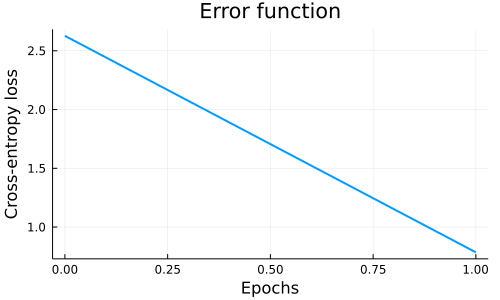

In [16]:
losses = report(mach)[1][1]
epochs = pipe.neural_network_classifier.epochs
plot(0:epochs, losses, title="Error function", size=(500,300), linewidth=2, legend=false)
xlabel!("Epochs")
ylabel!("Cross-entropy loss")

### Predict the outcome


In [17]:
ŷ = predict_mode(mach, X)
ŷ[1:5]

5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 8
 2
 6
 2
 7

In [18]:
printMetrics(ŷ, y)

10×10 Matrix{Int64}:
 4002     1    30    14     9    54    23    19    25    23
    0  4598    34    22    16    15    15    30    95     6
   26    23  3773   117    34    30    31    51    88    11
   10    22    68  3844     1   161     0    15   135    55
    6     5    39     6  3822    34    18    44    36   229
   51    18    11   144     3  3293    61     1   171    13
   27     4    66    13    51    71  3979     5    33     3
    8    15    59    57    16    31     3  4145    25   220
   15    27    80    40    16    59    12     7  3411    24
    1     6    11    35   121    47     1    69    77  3580

accuracy: 0.915
f1-score: 0.914


### Evaluate